In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
PATH="../../../Datas/Grape/"
PATH_SHUFFLE="../../../Datas/shuffle/"
PATH_NEW_DATAS="../../../Datas/new/"
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
EPOCHS = 5
INIT_LR =1e-4

In [3]:
from CNN.common.data_generation import shuffle_images_in_directories

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)

shuffle_images_in_directories(PATH+"BLACK_ROT/", PATH_SHUFFLE+"BLACK_ROT/", IMG_SIZE)
shuffle_images_in_directories(PATH+"ESCA/", PATH_SHUFFLE+"ESCA/", IMG_SIZE)
shuffle_images_in_directories(PATH+"HEALTHY/", PATH_SHUFFLE+"HEALTHY/", IMG_SIZE)
shuffle_images_in_directories(PATH+"LEAF_BLIGHT/", PATH_SHUFFLE+"LEAF_BLIGHT/", IMG_SIZE)

train_ds = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=PATH_SHUFFLE,
                                               shuffle=True,
                                               target_size=IMG_SIZE,
                                               subset="training",
                                               class_mode='categorical')

val_ds = image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=PATH_SHUFFLE,
                                             shuffle=True,
                                             target_size=IMG_SIZE,
                                             subset="validation",
                                             class_mode='categorical')

Found 7399 images belonging to 4 classes.
Found 1849 images belonging to 4 classes.


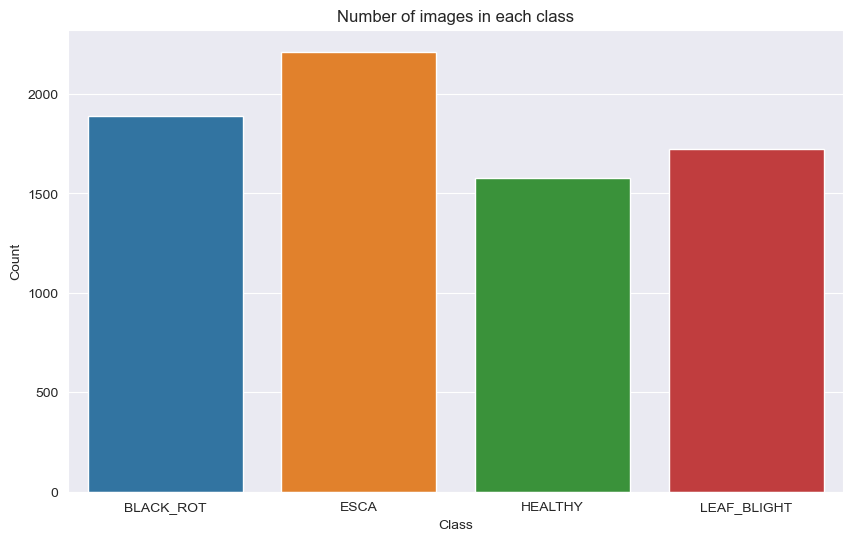

In [4]:
# Get class labels
class_labels = list(train_ds.class_indices.keys())

# Get number of images in each class
class_counts = np.bincount(train_ds.labels)

# Create a DataFrame with class labels and counts
class_counts_df = pd.DataFrame({
    'Class': class_labels,
    'Count': class_counts
})

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(data=class_counts_df, x='Class', y='Count')
plt.title('Number of images in each class')
plt.show()

In [5]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [6]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,) # R,G,B Channels
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [7]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [8]:
# Add a global spatial average pooling layer
out = base_model.output
out = tf.keras.layers.GlobalAveragePooling2D()(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
out = tf.keras.layers.Dense(512, activation='relu')(out)
predictions = tf.keras.layers.Dense(4, activation='softmax')(out)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers and use theyas feature extractor trained ln imagenet
for layer in base_model.layers:
    layer.trainable = False

# Compile
opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           

In [9]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

29/29 [==============================] - 19s 474ms/step - loss: 1.5380 - accuracy: 0.2580
initial loss: 1.54
initial accuracy: 0.26


In [10]:
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/5
116/116 [==============================] - 59s 464ms/step - loss: 0.7271 - accuracy: 0.7235 - val_loss: 0.7696 - val_accuracy: 0.6712
Epoch 2/5
116/116 [==============================] - 13s 108ms/step - loss: 0.4428 - accuracy: 0.8286 - val_loss: 0.6166 - val_accuracy: 0.7469
Epoch 3/5
116/116 [==============================] - 13s 115ms/step - loss: 0.3717 - accuracy: 0.8554 - val_loss: 0.5811 - val_accuracy: 0.7545
Epoch 4/5
116/116 [==============================] - 13s 115ms/step - loss: 0.3316 - accuracy: 0.8670 - val_loss: 0.5668 - val_accuracy: 0.7577
Epoch 5/5
116/116 [==============================] - 14s 117ms/step - loss: 0.3012 - accuracy: 0.8808 - val_loss: 0.5070 - val_accuracy: 0.7902


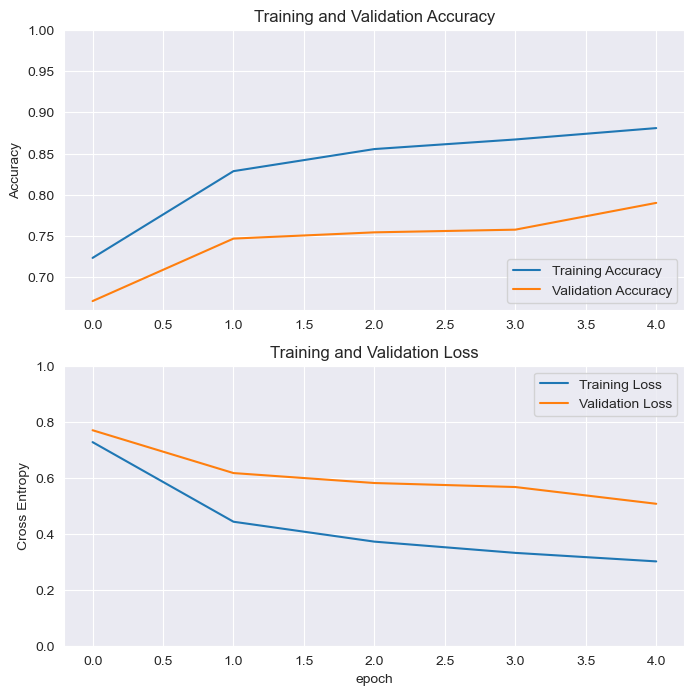

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
base_model.trainable = True

In [13]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [14]:
fine_tune_epochs = 5
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 5/10
116/116 [==============================] - 13s 114ms/step - loss: 0.2755 - accuracy: 0.8894 - val_loss: 0.5225 - val_accuracy: 0.7777
Epoch 6/10
116/116 [==============================] - 13s 112ms/step - loss: 0.2472 - accuracy: 0.9080 - val_loss: 0.5119 - val_accuracy: 0.7939
Epoch 7/10
116/116 [==============================] - 13s 111ms/step - loss: 0.2357 - accuracy: 0.9135 - val_loss: 0.4950 - val_accuracy: 0.7977
Epoch 8/10
116/116 [==============================] - 13s 112ms/step - loss: 0.2170 - accuracy: 0.9193 - val_loss: 0.5559 - val_accuracy: 0.7756
Epoch 9/10
116/116 [==============================] - 14s 120ms/step - loss: 0.1992 - accuracy: 0.9280 - val_loss: 0.5368 - val_accuracy: 0.7777
Epoch 10/10
116/116 [==============================] - 13s 115ms/step - loss: 0.1855 - accuracy: 0.9336 - val_loss: 0.5116 - val_accuracy: 0.7875


In [15]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

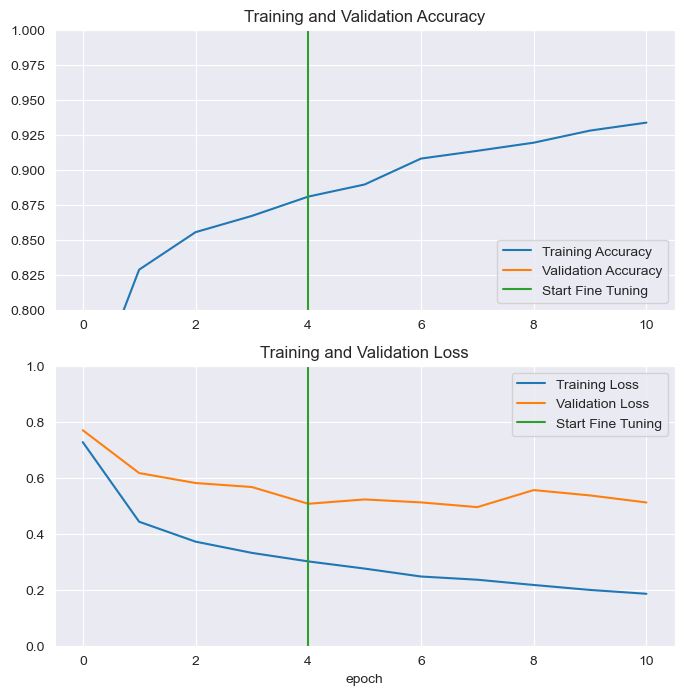

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
final_loss, final_accuracy = model.evaluate(val_ds)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}".format(final_accuracy))

29/29 [==============================] - 3s 87ms/step - loss: 0.5116 - accuracy: 0.7875
Final loss: 0.51
Final accuracy: 0.79


In [18]:
model.save('model.h5')